<a href="https://colab.research.google.com/github/nadeyyah/Vegetable-Image-Classification-WIth-CNN-/blob/main/Copy_of_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Vegetables
- **Nama:** Nadia Alzena Zahrani
- **Email:** nadiaalzenaz@student.ub.ac.id
- **ID Dicoding:** nadeyyah

## Import Semua Packages/Library yang Digunakan

In [1]:
! pip install kagglehub

In [3]:
# install tensorflow js
!pip install tensorflowjs

In [4]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import DenseNet201,preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,MaxPooling2D,Dense,Lambda, Dropout
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs

In [5]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [6]:
print("Tensorflow.Js version:", tfjs.__version__)

Tensorflow.Js version: 4.22.0


In [7]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub
import shutil
import random
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Data Preparation

### Data Loading

In [8]:
#import dataset dari kaggle
nama_dataset = "misrakahmed/vegetable-image-dataset"
lokasi_dataset = kagglehub.dataset_download(nama_dataset)
print("Lokasi dataset:", lokasi_dataset)
# Memeriksa isi folder dataset
files = os.listdir(lokasi_dataset)
print("Daftar file dalam folder dataset:", files)

Lokasi dataset: /kaggle/input/vegetable-image-dataset
Daftar file dalam folder dataset: ['Vegetable Images']


In [10]:
#simpan ke colab
lokasi_dataset = "/kaggle/input/vegetable-image-dataset"
colab_dataset_folder = "/content/vegetable-dataset"
# Membuat folder tujuan
os.makedirs(colab_dataset_folder, exist_ok=True)
# Menyalin dataset dari lokasi unduhan ke folder tujuan di Colab
shutil.copytree(lokasi_dataset, colab_dataset_folder, dirs_exist_ok=True)
print(f"Dataset telah disalin ke: {colab_dataset_folder}")

Dataset telah disalin ke: /content/vegetable-dataset


In [11]:
#mengabungkan dataset folder train, test, validasi menjadi 1 folder yang sama berdasarkan kelasnya
# Lokasi folder dataset asli di Colab
original_dataset_dir = "/content/vegetable-dataset/Vegetable Images"
# Lokasi folder baru untuk dataset yang digabungkan
combined_dataset_dir = "/content/vegetable-dataset-combined"
os.makedirs(combined_dataset_dir, exist_ok=True)

In [12]:
# Daftar kelas
classes = [
    "Bean", "Bitter_Gourd", "Bottle_Gourd", "Brinjal", "Broccoli",
    "Cabbage", "Capsicum", "Carrot", "Cauliflower", "Cucumber",
    "Papaya", "Potato", "Pumpkin", "Radish", "Tomato"
]

In [13]:
# Menggabungkan dataset berdasarkan kelas
for cls in classes:
    cls_combined_folder = os.path.join(combined_dataset_dir, cls)
    os.makedirs(cls_combined_folder, exist_ok=True)
    # Lokasi folder masing-masing dataset
    for dataset_type in ["train", "validation", "test"]:
        cls_original_folder = os.path.join(original_dataset_dir, dataset_type, cls)

        if os.path.exists(cls_original_folder):
            for filename in os.listdir(cls_original_folder):
                src = os.path.join(cls_original_folder, filename)
                dst = os.path.join(cls_combined_folder, filename)
                shutil.copy2(src, dst)

print(f"Dataset berhasil digabungkan ke folder: {combined_dataset_dir}")

Dataset berhasil digabungkan ke folder: /content/vegetable-dataset-combined


### Data Preprocessing

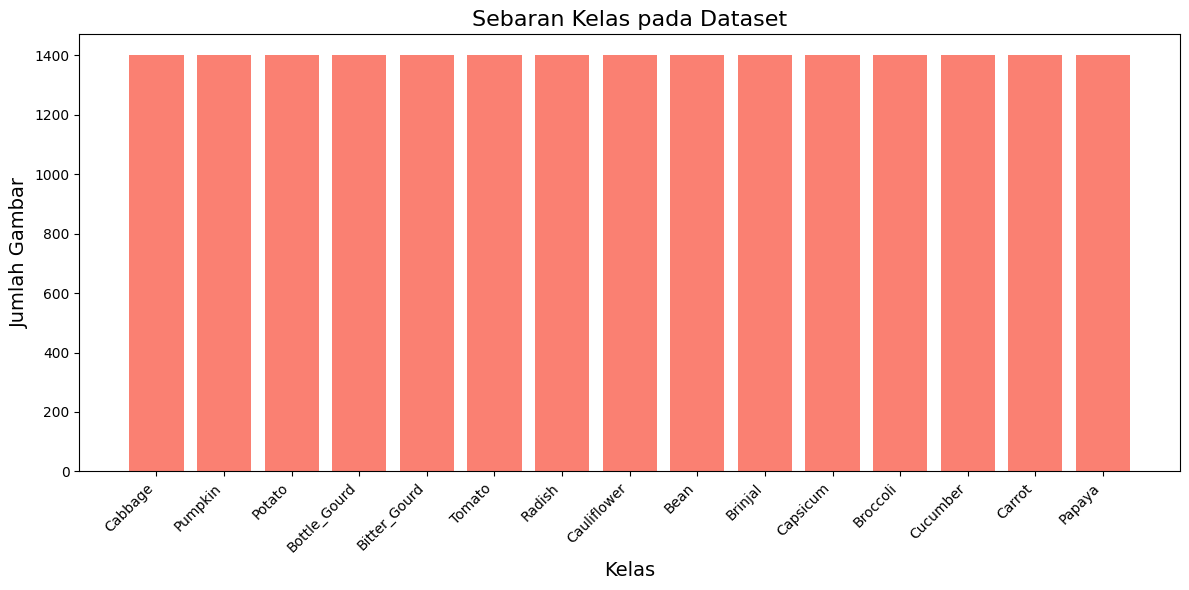

In [14]:
#Sebaran kelas pada dataset
class_distribution = {}
for cls in os.listdir(combined_dataset_dir):
    class_folder = os.path.join(combined_dataset_dir, cls)
    if os.path.isdir(class_folder):
        num_files = len(os.listdir(class_folder))
        class_distribution[cls] = num_files

classes = list(class_distribution.keys())
counts = list(class_distribution.values())

# Membuat grafik
plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.title("Sebaran Kelas pada Dataset", fontsize=16)
plt.xlabel("Kelas", fontsize=14)
plt.ylabel("Jumlah Gambar", fontsize=14)
plt.tight_layout()
plt.show()

#### Split Dataset

In [15]:
#membuat folder untuk menyimpan split
folder_name = 'vegetable-dataset-split'

# Membuat folder jika belum ada
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"📂 Folder baru dibuat: {folder_name}")
else:
    print(f"📂 Folder sudah ada: {folder_name}")

📂 Folder baru dibuat: vegetable-dataset-split


In [16]:
# Lokasi dataset asli dan direktori output
source_dir = '/content/vegetable-dataset-combined'
output_dir = '/content/vegetable-dataset-split'

In [17]:
# Proporsi pembagian dataset
split_ratios = {'train': 0.7, 'validation': 0.15, 'test': 0.15}

In [18]:
# Daftar kategori
categories = [
    'Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage',
    'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato',
    'Pumpkin', 'Radish', 'Tomato'
]

In [19]:
# Membuat folder tujuan baru berdasarkan kategori dan subset
def create_output_directories():
    for subset in split_ratios.keys():
        for category in categories:
            category_path = os.path.join(output_dir, subset, category)
            os.makedirs(category_path, exist_ok=True)

In [20]:
# Fungsi untuk membagi dataset ke dalam subset berdasarkan kategori
def distribute_to_new_directory(category_name):
    input_path = os.path.join(source_dir, category_name)  # Menghapus '/train' dari path
    subset_paths = {subset: os.path.join(output_dir, subset, category_name) for subset in split_ratios.keys()}

    # Pastikan folder input_path ada
    if not os.path.exists(input_path):
        print(f"Folder {input_path} tidak ditemukan!")
        return

    # Mendapatkan daftar file gambar di folder kategori
    image_files = [img for img in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, img))]
    random.shuffle(image_files)

    # Menghitung jumlah file untuk setiap subset
    total_images = len(image_files)
    train_limit = int(split_ratios['train'] * total_images)
    validation_limit = train_limit + int(split_ratios['validation'] * total_images)

    subsets = {
        'train': image_files[:train_limit],
        'validation': image_files[train_limit:validation_limit],
        'test': image_files[validation_limit:]
    }

    # Menyalin file ke folder tujuan baru
    for subset, file_list in subsets.items():
        for file_name in file_list:
            src_path = os.path.join(input_path, file_name)
            dest_path = os.path.join(subset_paths[subset], file_name)
            shutil.copy2(src_path, dest_path)

# Membuat folder tujuan terlebih dahulu
create_output_directories()

# Memproses setiap kategori dan memindahkan dataset
for vegetable in categories:
    distribute_to_new_directory(vegetable)

print(f"✅ Dataset berhasil dipindahkan dan dibagi ke dalam folder baru: {output_dir}")


✅ Dataset berhasil dipindahkan dan dibagi ke dalam folder baru: /content/vegetable-dataset-split


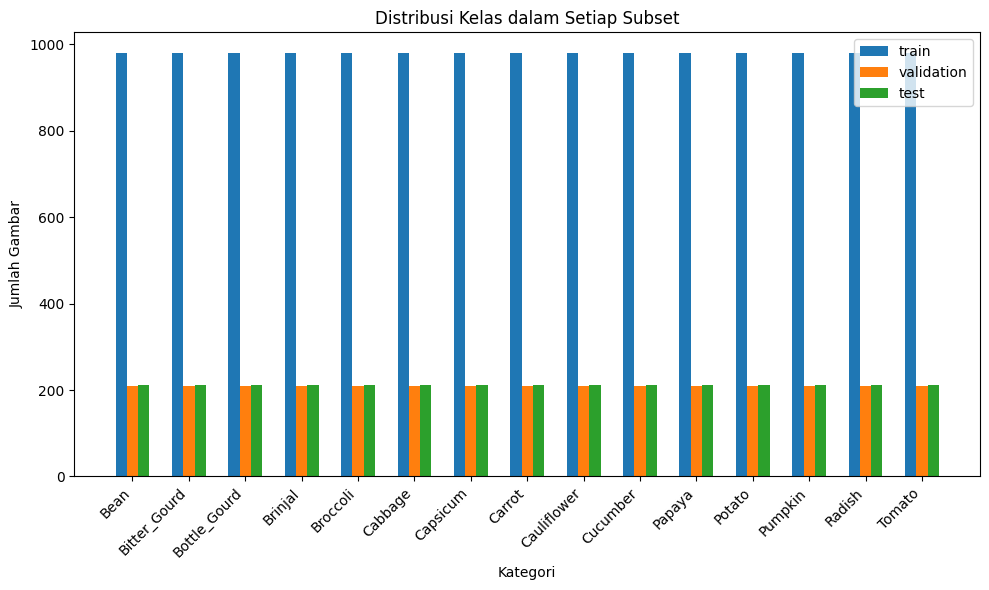

In [21]:
# menampilkan distribusi kelas dalam diagram batang
def plot_class_distribution():
    distribution = {subset: {category: 0 for category in categories} for subset in split_ratios.keys()}

    for subset in split_ratios.keys():
        for category in categories:
            category_path = os.path.join(output_dir, subset, category)
            if os.path.exists(category_path):
                distribution[subset][category] = len(os.listdir(category_path))

    # Menyiapkan data untuk diagram batang
    fig, ax = plt.subplots(figsize=(10, 6))

    subset_labels = list(split_ratios.keys())
    category_labels = categories

    # Mengatur posisi batang pada sumbu X
    bar_width = 0.2
    index = range(len(category_labels))

    # Membuat diagram batang untuk setiap subset
    for i, subset in enumerate(subset_labels):
        values = [distribution[subset][category] for category in category_labels]
        ax.bar(
            [x + bar_width * i for x in index],
            values,
            bar_width,
            label=subset
        )

    # Menambahkan label, judul, dan keterangan
    ax.set_xlabel('Kategori')
    ax.set_ylabel('Jumlah Gambar')
    ax.set_title('Distribusi Kelas dalam Setiap Subset')
    ax.set_xticks([x + bar_width for x in index])
    ax.set_xticklabels(category_labels, rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Memanggil fungsi untuk menampilkan distribusi kelas
plot_class_distribution()


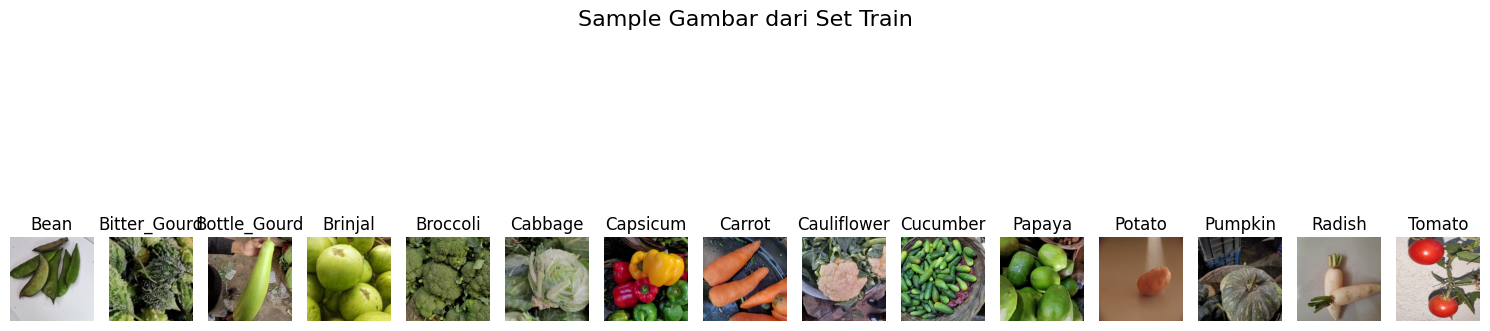

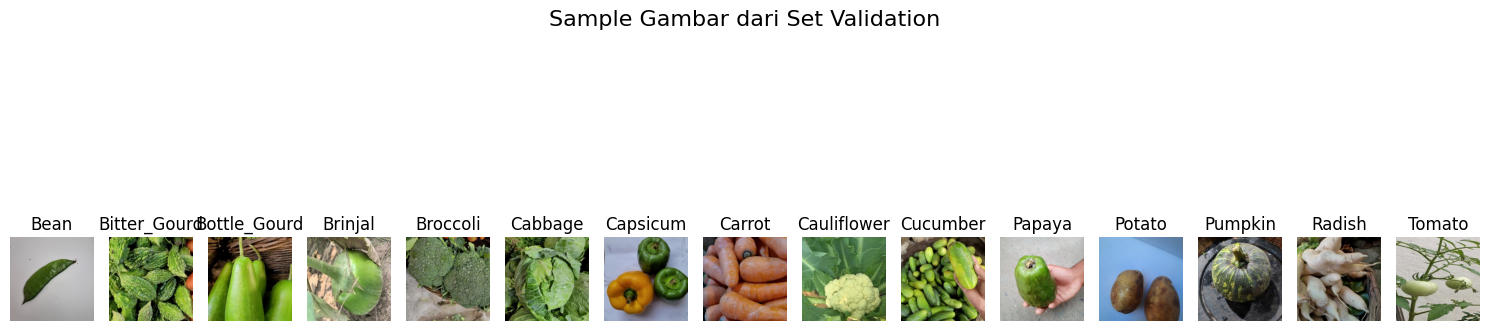

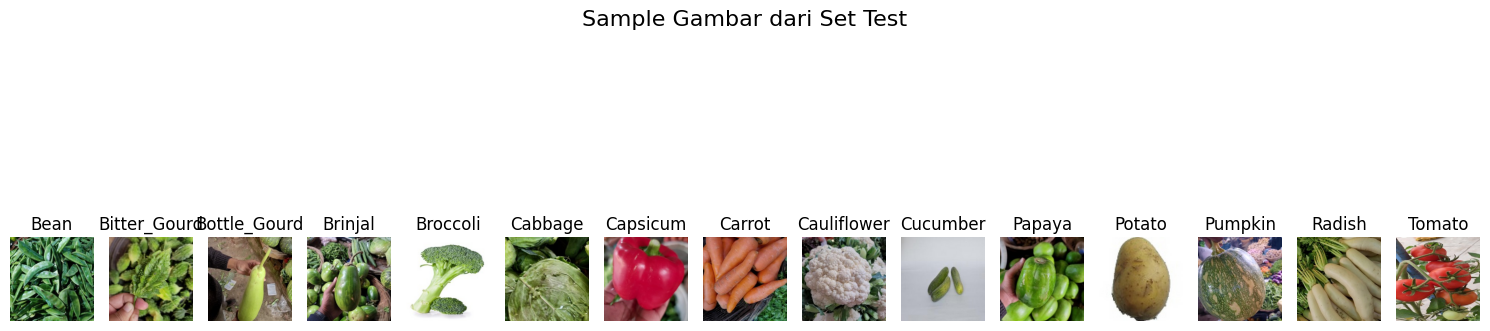

In [22]:
# menampilkan sampel dari setiap subset
def show_sample_images():
    subset_labels = list(split_ratios.keys())  # ['train', 'validation', 'test']

    for subset in subset_labels:
        fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
        fig.suptitle(f'Sample Gambar dari Set {subset.capitalize()}', fontsize=16)

        for i, category in enumerate(categories):
            category_path = os.path.join(output_dir, subset, category)
            if os.path.exists(category_path):
                image_files = os.listdir(category_path)
                random_image = random.choice(image_files)
                image_path = os.path.join(category_path, random_image)
                img = mpimg.imread(image_path)
                axes[i].imshow(img)
                axes[i].axis('off')
                axes[i].set_title(category)

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()
show_sample_images()

In [23]:
# memeriksa resolusi gambar di setiap kategori dan subset
def check_image_resolution():
    subset_labels = list(split_ratios.keys())  # ['train', 'validation', 'test']

    for subset in subset_labels:
        print(f"Resolusi Gambar di Set {subset.capitalize()}:")

        for category in categories:
            category_path = os.path.join(output_dir, subset, category)
            if os.path.exists(category_path):
                print(f"  Kategori: {category}")
                # Iterasi melalui gambar di folder kategori
                for image_file in os.listdir(category_path):
                    image_path = os.path.join(category_path, image_file)
                    if os.path.isfile(image_path):
                        # Membaca gambar menggunakan PIL
                        with Image.open(image_path) as img:
                            width, height = img.size
                            print(f"    {image_file}: {width} x {height}")

check_image_resolution()

Streaming output truncated to the last 5000 lines.
    0563.jpg: 224 x 224
    0695.jpg: 224 x 224
    0369.jpg: 224 x 224
    0781.jpg: 224 x 224
    0647.jpg: 224 x 224
    0177.jpg: 224 x 224
    0225.jpg: 224 x 224
    0497.jpg: 224 x 224
    0610.jpg: 224 x 224
    0517.jpg: 224 x 224
    0985.jpg: 224 x 224
    0876.jpg: 224 x 224
    0680.jpg: 224 x 224
    0213.jpg: 224 x 224
    0471.jpg: 224 x 224
    1194.jpg: 224 x 224
    0092.jpg: 224 x 224
    1032.jpg: 224 x 224
    0644.jpg: 224 x 224
    1324.jpg: 224 x 224
    0347.jpg: 224 x 224
    0107.jpg: 224 x 224
    1001.jpg: 224 x 224
    1220.jpg: 224 x 224
    0153.jpg: 224 x 224
    1100.jpg: 224 x 224
    0677.jpg: 224 x 224
    1257.jpg: 224 x 224
    0099.jpg: 224 x 224
    1287.jpg: 224 x 224
    0475.jpg: 224 x 224
    1368.jpg: 224 x 224
    0635.jpg: 224 x 224
    1283.jpg: 224 x 224
    0595.jpg: 224 x 224
    0422.jpg: 224 x 224
    0361.jpg: 224 x 224
    0819.jpg: 224 x 224
    0426.jpg: 224 x 224
    1242.jpg:

## Evaluasi dan Visualisasi

In [24]:
#path direktori
train = "/content/vegetable-dataset-split/train"
test = "/content/vegetable-dataset-split/test"
validation = "/content/vegetable-dataset-split/validation"

In [25]:
# image size & batch size
img_sz = (224,224)
batch_sz = 32

In [26]:
# Data Augmentation untuk Train dan Normalisasi untuk Validation/Test
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_data_gen = ImageDataGenerator(rescale=1./255)

In [27]:
# menyaring file gambar
def get_image_files_from_directory(directory):
    """Menyaring file non-gambar dan mengembalikan daftar path gambar."""
    valid_image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    return [
        os.path.join(directory, file)
        for file in os.listdir(directory)
        if file.lower().endswith(valid_image_extensions) and os.path.isfile(os.path.join(directory, file))
    ]

In [28]:
# Menyiapkan generator untuk data Train, Validation, dan Test
train_dataset_gen = train_data_gen.flow_from_directory(
    train,
    target_size=img_sz,
    batch_size=batch_sz,
    class_mode='categorical'
)

Found 14685 images belonging to 15 classes.


In [29]:
validation_dataset_gen = val_test_data_gen.flow_from_directory(
    validation,
    target_size=img_sz,
    batch_size=batch_sz,
    class_mode='categorical'
)

Found 3150 images belonging to 15 classes.


In [30]:
test_dataset_gen = val_test_data_gen.flow_from_directory(
    test,
    target_size=img_sz,
    batch_size=batch_sz,
    class_mode='categorical',
    shuffle=False
)

Found 3165 images belonging to 15 classes.


In [31]:
# Membangun model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(15, activation='softmax')
])

# Kompilasi model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Menyusun model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,787,471 (98.37 MB)

 Trainable params: 25,787,471 (98.37 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
checkpoint = ModelCheckpoint(
    'model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)
callbacks = [checkpoint, early_stopping, reduce_lr]

In [33]:
# Melatih model
history = model.fit(
    train_dataset_gen,  # Data training
    epochs=15,        # Jumlah epoch
    validation_data=validation_dataset_gen,  # Data validasi
    callbacks=callbacks,  # Callback untuk kontrol pelatihan
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.3074 - loss: 2.0974
Epoch 1: val_accuracy improved from -inf to 0.69397, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 195s 409ms/step - accuracy: 0.3076 - loss: 2.0965 - val_accuracy: 0.6940 - val_loss: 0.9101 - learning_rate: 0.0010
Epoch 2/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6544 - loss: 1.0383
Epoch 2: val_accuracy improved from 0.69397 to 0.81460, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 185s 403ms/step - accuracy: 0.6545 - loss: 1.0382 - val_accuracy: 0.8146 - val_loss: 0.6141 - learning_rate: 0.0010
Epoch 3/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7485 - loss: 0.7811
Epoch 3: val_accuracy improved from 0.81460 to 0.84222, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 203s 405ms/step - accuracy: 0.7485 - loss: 0.7810 - val_accuracy: 0.8422 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 4/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7990 - loss: 0.6284
Epoch 4: val_accuracy improved from 0.84222 to 0.92825, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 201s 403ms/step - accuracy: 0.7990 - loss: 0.6283 - val_accuracy: 0.9283 - val_loss: 0.2771 - learning_rate: 0.0010
Epoch 5/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8219 - loss: 0.5500
Epoch 5: val_accuracy did not improve from 0.92825
459/459 ━━━━━━━━━━━━━━━━━━━━ 198s 393ms/step - accuracy: 0.8219 - loss: 0.5500 - val_accuracy: 0.9159 - val_loss: 0.2537 - learning_rate: 0.0010
Epoch 6/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8406 - loss: 0.4972
Epoch 6: val_accuracy did not improve from 0.92825
459/459 ━━━━━━━━━━━━━━━━━━━━ 180s 393ms/step - accuracy: 0.8406 - loss: 0.4972 - val_accuracy: 0.9219 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 7/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8568 - loss: 0.4519
Epoch 7: val_accuracy improved from 0.92825 to 0.94190, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 179s 389ms/step - accuracy: 0.8568 - loss: 0.4518 - val_accuracy: 0.9419 - val_loss: 0.2108 - learning_rate: 0.0010
Epoch 8/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8712 - loss: 0.4199
Epoch 8: val_accuracy did not improve from 0.94190
459/459 ━━━━━━━━━━━━━━━━━━━━ 178s 389ms/step - accuracy: 0.8712 - loss: 0.4199 - val_accuracy: 0.9397 - val_loss: 0.1944 - learning_rate: 0.0010
Epoch 9/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8756 - loss: 0.3959
Epoch 9: val_accuracy improved from 0.94190 to 0.96540, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 183s 398ms/step - accuracy: 0.8756 - loss: 0.3958 - val_accuracy: 0.9654 - val_loss: 0.1322 - learning_rate: 0.0010
Epoch 10/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8871 - loss: 0.3572
Epoch 10: val_accuracy did not improve from 0.96540
459/459 ━━━━━━━━━━━━━━━━━━━━ 180s 392ms/step - accuracy: 0.8871 - loss: 0.3572 - val_accuracy: 0.9648 - val_loss: 0.1340 - learning_rate: 0.0010
Epoch 11/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8971 - loss: 0.3339
Epoch 11: val_accuracy did not improve from 0.96540

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
459/459 ━━━━━━━━━━━━━━━━━━━━ 180s 391ms/step - accuracy: 0.8971 - loss: 0.3339 - val_accuracy: 0.9597 - val_loss: 0.1341 - learning_rate: 0.0010
Epoch 12/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9243 - loss: 0.2401
Epoch 12: val_accuracy improved from 0.96540 to 0.96952, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 183s 398ms/step - accuracy: 0.9244 - loss: 0.2400 - val_accuracy: 0.9695 - val_loss: 0.1194 - learning_rate: 5.0000e-04
Epoch 13/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9335 - loss: 0.2201
Epoch 13: val_accuracy improved from 0.96952 to 0.97714, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 189s 411ms/step - accuracy: 0.9335 - loss: 0.2201 - val_accuracy: 0.9771 - val_loss: 0.0816 - learning_rate: 5.0000e-04
Epoch 14/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9351 - loss: 0.2125
Epoch 14: val_accuracy improved from 0.97714 to 0.98159, saving model to model_best.h5


459/459 ━━━━━━━━━━━━━━━━━━━━ 185s 402ms/step - accuracy: 0.9351 - loss: 0.2125 - val_accuracy: 0.9816 - val_loss: 0.0749 - learning_rate: 5.0000e-04
Epoch 15/15
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9427 - loss: 0.1841
Epoch 15: val_accuracy did not improve from 0.98159
459/459 ━━━━━━━━━━━━━━━━━━━━ 180s 392ms/step - accuracy: 0.9427 - loss: 0.1841 - val_accuracy: 0.9775 - val_loss: 0.0871 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 14.


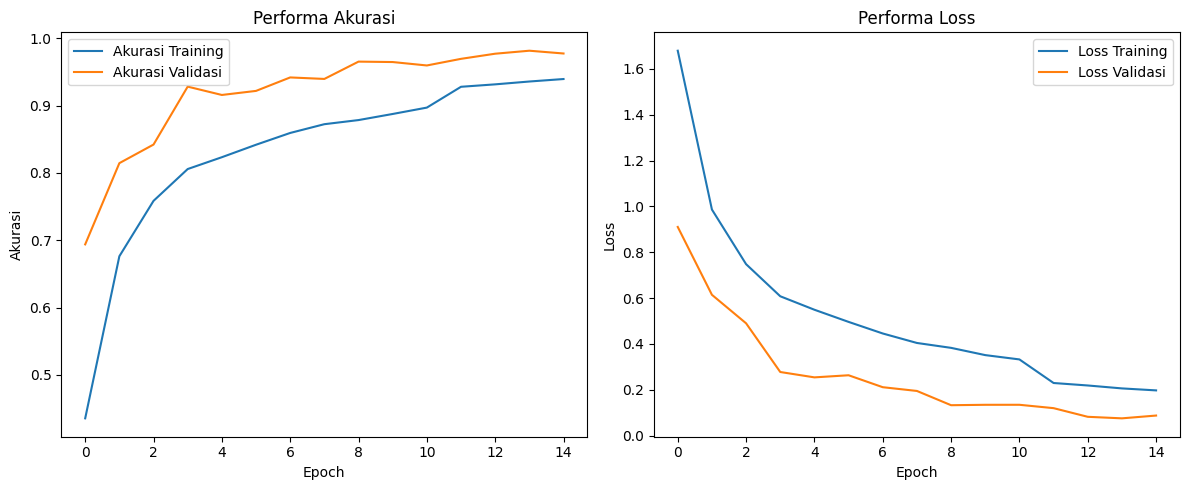

In [34]:
# Visualisasi Hasil Pelatihan
def plot_training_history(history):
    # Plot akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Akurasi Training')
    plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.title('Performa Akurasi')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Training')
    plt.plot(history.history['val_loss'], label='Loss Validasi')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Performa Loss')

    plt.tight_layout()
    plt.show()

# Tampilkan grafik pelatihan
plot_training_history(history)

In [35]:
# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_dataset_gen)
print(f"✅ Akurasi Model pada Data Uji: {test_acc * 100:.2f}%")

99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9859 - loss: 0.0609
✅ Akurasi Model pada Data Uji: 97.98%


In [36]:
# Prediksi dan Evaluasi
# Mendapatkan label sebenarnya dan prediksi model
true_labels = test_dataset_gen.classes  # Label sebenarnya
predictions = np.argmax(model.predict(test_dataset_gen), axis=-1)  # Prediksi model

# Laporan Klasifikasi
class_labels = list(test_dataset_gen.class_indices.keys())
report = classification_report(true_labels, predictions, target_names=class_labels)
print("Laporan Klasifikasi:")
print(report)

99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
Laporan Klasifikasi:
              precision    recall  f1-score   support

        Bean       0.99      1.00      0.99       211
Bitter_Gourd       0.99      1.00      0.99       211
Bottle_Gourd       0.95      1.00      0.98       211
     Brinjal       0.96      0.96      0.96       211
    Broccoli       0.98      0.97      0.97       211
     Cabbage       0.97      0.98      0.97       211
    Capsicum       1.00      1.00      1.00       211
      Carrot       0.98      0.98      0.98       211
 Cauliflower       0.98      0.97      0.98       211
    Cucumber       1.00      0.99      0.99       211
      Papaya       0.98      0.93      0.96       211
      Potato       1.00      0.98      0.99       211
     Pumpkin       0.98      0.98      0.98       211
      Radish       1.00      1.00      1.00       211
      Tomato       0.95      0.98      0.97       211

    accuracy                           0.98      3165
   macro avg       

## Konversi Model

In [38]:
import tensorflowjs as tfjs

# direktori untuk menyimpan model TensorFlow.js
tfjs_model_dir = "tfjs_model/tfjs_model"
os.makedirs(tfjs_model_dir, exist_ok=True)

# menyimpan model ke dalam format TensorFlow.js
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print("✅ Model disimpan dalam format TensorFlow.js di:", tfjs_model_dir)


failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model disimpan dalam format TensorFlow.js di: tfjs_model/tfjs_model


In [39]:
import tensorflow as tf

# direktori untuk menyimpan model TensorFlow Lite
tflite_model_dir = "tflite/tflite"
os.makedirs(tflite_model_dir, exist_ok=True)

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# menyimpan model TensorFlow Lite ke file
tflite_model_path = os.path.join(tflite_model_dir, "model.tflite")
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("✅ Model disimpan dalam format TensorFlow Lite di:", tflite_model_path)

# menyimpan label kelas ke file label.txt
label_file_path = os.path.join(tflite_model_dir, "label.txt")
with open(label_file_path, 'w') as f:
    for label in classes:
        f.write(label + '\n')

print("✅ Label kelas disimpan di:", label_file_path)


Saved artifact at '/tmp/tmpbt2s04fu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  132847334325520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847334326096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847334325328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847244691216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847244692368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847244692944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847334325712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847244693328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847244693712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132847244695248: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model disimpa

In [43]:
import os
import tensorflow as tf

# Direktori untuk menyimpan model
saved_model_dir = "saved_model"
os.makedirs(saved_model_dir, exist_ok=True)

# Nama file model dalam format Keras
keras_model_file = os.path.join(saved_model_dir, "model_best.keras")

# Simpan model dalam format Keras
model.save(keras_model_file)
print(f"✅ Model disimpan dalam format Keras di: {keras_model_file}")

✅ Model disimpan dalam format Keras di: saved_model/model_best.keras


## Inference (Optional)

In [44]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

# Daftar kelas sayuran
classes = [
    "Bean", "Bitter_Gourd", "Bottle_Gourd", "Brinjal", "Broccoli",
    "Cabbage", "Capsicum", "Carrot", "Cauliflower", "Cucumber",
    "Papaya", "Potato", "Pumpkin", "Radish", "Tomato"
]

def load_tflite_model(model_path):
    """
    Fungsi untuk memuat model TensorFlow Lite.
    """
    interpreter = tf.lite.Interpreter(model_path="/content/tflite/tflite/model.tflite")
    interpreter.allocate_tensors()
    return interpreter

def preprocess_image(img_path, target_size=(224, 224)):
    """
    Fungsi untuk memproses gambar agar sesuai dengan input model.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img, img_array

def predict_with_tflite(interpreter, img_array):
    """
    Fungsi untuk melakukan prediksi menggunakan model TensorFlow Lite.
    """
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(predictions)
    return predicted_class

def main(img_path):
    model_path = "model_best.tflite"
    print("📥 Loading TensorFlow Lite model...")
    interpreter = load_tflite_model(model_path)
    print("✅ Model loaded successfully!")
    print("🖼️ Preprocessing image...")
    img, img_array = preprocess_image(img_path)
    print("✅ Image preprocessed!")
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()
    print("🔍 Performing prediction...")
    predicted_class = predict_with_tflite(interpreter, img_array)
    print(f"✅ Predicted class: {classes[predicted_class]}")

📥 Loading TensorFlow Lite model...
✅ Model loaded successfully!
🖼️ Preprocessing image...
✅ Image preprocessed!


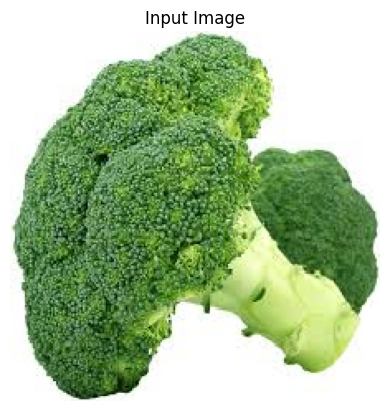

🔍 Performing prediction...
✅ Predicted class: Broccoli


In [46]:
# Menjalalkan program
img_path = "/content/images_1.jpeg"
main(img_path)

📥 Loading TensorFlow Lite model...
✅ Model loaded successfully!
🖼️ Preprocessing image...
✅ Image preprocessed!


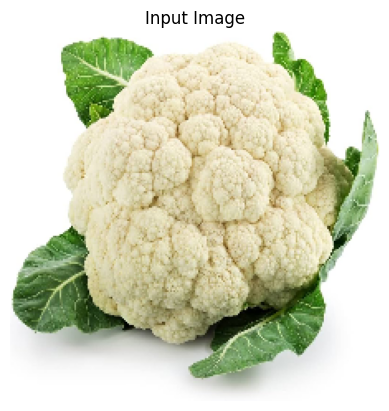

🔍 Performing prediction...
✅ Predicted class: Cauliflower


In [47]:
img_path = "/content/images_2.jpg"
main(img_path)